## Resource Type Prediction for DBpedia
1. Generate summary text from question text for Resource type questions
2. Extract keyword from summary
3. Match the keyword against list of labels mapped to ontology classes

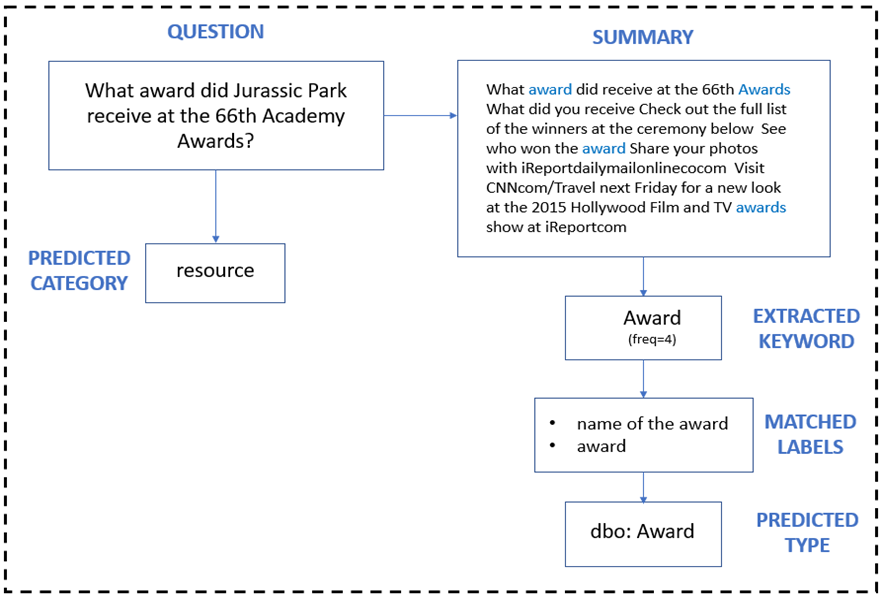

In [ ]:
!pip3 install truecase

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import truecase

ps = PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))

import spacy
nlp = spacy.load('en_core_web_sm')

from transformers import pipeline
summarizer = pipeline("summarization")

### Read  data

In [ ]:
#result file from Category Prediction
test = pd.read_csv('../input/dbpedia/dbpedia_type_predictions_v1.0.csv')
test

In [ ]:
#generated labels for ontology classes
col = ['ontology','type']
wiki_labels = pd.read_csv('../input/dbpedia/class_labels_piped.txt',sep='|',names=col)
ontology = wiki_labels.ontology
ontology = ontology.str.replace('http://dbpedia.org/ontology/','')
wiki_labels.ontology = ontology
wiki_labels.head(10)

In [ ]:
#file containing ontology classes mapped to its hierarchy of classes
col = ['ontology','classes']
labels = pd.read_csv('../input/dbpedia/superclasses.tsv',sep='|',names=col)
labels['classes'] =  labels['classes'].astype(str) +']'
labels.head(10)

### Extract Keyword from Summary

In [ ]:
# function to create summaries of Questions using summarizer pipeline
def Summary_to_keyword(question):
  to_tokenize = question
  summarized = summarizer(to_tokenize, min_length=75, max_length=100)
  summarized = str(summarized[0].values()).replace('dict_values','')
  return summarized

In [ ]:
# function for calculating the frequency
def freq(text,question):
    hintword = ''
    max_count=0
    lemmatizer = WordNetLemmatizer()

    # break the string into list of words
    str_list = text.split()
    str_list = [lemmatizer.lemmatize(word) for word in str_list]
    str_list = [w for w in str_list if not w.lower() in stop_words]
    
    # gives set of unique words
    unique_words = set(str_list)
    
    keywordFound=False
    for words in unique_words :
        count = str_list.count(words)
        if(count>max_count and words in question.split()):
            max_count = count
            hintword = words
            keywordFound=True
        if keywordFound==False:
            if(count>max_count and ps.stem(words) in question.split()):
                max_count = count
                hintword = ps.stem(words)
    return hintword

In [ ]:
# function to match keyword with labels
def extract_type(hintword):
    types = []
    ontologies = []
    typeFound = False
    for j in range(len(labels)):
        if hintword.lower() == labels.loc[j,'ontology'].lower():
            types.append(labels.loc[j,'ontology'])
            types.append(labels.loc[j,'classes'])
            ontologies.append(wiki_labels.loc[j,'ontology'])
            typeFound = True
    if typeFound == False:
        for j in range(len(wiki_labels)):
            if hintword.lower() in wiki_labels.loc[j,'type'].lower():
                label = wiki_labels.loc[j,'ontology']
                for j in range(len(labels)):
                    if label.lower() == labels.loc[j,'ontology'].lower():
                        types.append(labels.loc[j,'ontology'])
                        types.append(labels.loc[j,'classes'])
                ontologies.append(label)
    return str(list(set(types))), str(list(ontologies))

In [ ]:
#extract hintword
for i in range(0,9104):
    if(test.loc[i,'category'] == 'resource'):
        #truecasing
        print(i,'-',test.loc[i,'question'])
        question = str(test.loc[i,'question'].lower())
        question = re.sub('[!,*)@#%(&$_?.^]', '', str(question))
        question = truecase.get_true_case(question)
        #remove named entities
        question = nlp(question)
        question = " ".join([ent.text for ent in question if not ent.ent_type_])
        #remove proper nouns
        question = re.sub("[^\w]", " ",  question).split()
        edited_question = nltk.tag.pos_tag(question)
        edited_question = [word for word,tag in edited_question if tag != 'VBN' and tag != 'VBZ' and tag != 'VBD']
        edited_question = ' '.join(edited_question)
        summary = re.sub('[!,*)@#%(&$_?.^]', '', test.loc[i,'summary'])
        hintword = freq(test.loc[i,'summary'],edited_question)
        test.loc[i,'keyword'] = hintword
        types,ontologies = extract_type(str(test.loc[i,'keyword']))
        test.loc[i,'ontology'] = str(ontologies)
        test.loc[i,'type'] = str(types)

### Cleaning results

In [ ]:
#cleaning the output
for i in range(len(test)):
    if(test.loc[i,'category']=='literal'):
        if(str(test.loc[i,'type'])=='string'):
            test.loc[i,'type']=="['string']"
        if(str(test.loc[i,'type'])=='date'):
            test.loc[i,'type']=="['date']"
        if(str(test.loc[i,'type'])=='number'):
            test.loc[i,'type']=="['number']"
    if(test.loc[i,'category']=='boolean'):
        test.loc[i,'type']="['boolean']"

test

In [ ]:
#cleaning answer type
for i in range(len(test)):
    if(test.loc[i,'category']=='resource' and test.loc[i,'type']!='[]'):
        types = test.loc[i,'type'].replace('[','')
        types = types.replace(']','')
        types = types.replace('"','')
        types = types.replace("'",'')
        types = types.split(',')
        types = [s.strip() for s in types]
        types = list(set(types))
        types = list(filter(None, types))
        test.loc[i,'type'] = str(types)
test

In [ ]:
#write results to file
test.to_csv('dbpedia_type_predictions_v1.0.tsv', index=False, sep="\t")